# Federated learning local

**Prénom**: Alexandre \
**Nom**: Devaux Riviere \
**Login**: alexandre.devaux-riviere

In [1]:
import numpy as np
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from typing import List, Dict, Tuple, Callable

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

### 1. Load the MNIST dataset (or any other dataset like HAM 10000)

In [2]:
def get_mnist_data():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    train_dataset = torchvision.datasets.MNIST(
        root='./data',
        train=True,
        transform=transform,
        download=True,
    )

    test_dataset = torchvision.datasets.MNIST(
        root='./data',
        train=False,
        transform=transform,
        download=True,
    )

    return train_dataset, test_dataset

### 2. Extract two subsets of 600 data points each (without intersection)

In [3]:
def create_subsets(train_dataset, test_dataset, subset_size) -> List[Subset]:
    """Create non-overlapping subsets of the dataset (= 2 parts)"""
    indices = np.random.permutation(len(train_dataset))
    subset1 = Subset(train_dataset, indices[:subset_size])
    subset2 = Subset(train_dataset, indices[subset_size:subset_size*2])

    # 50 examples per local batch (written in the paper)
    train_loader_1 = DataLoader(subset1, batch_size=50, shuffle=True)
    train_loader_2 = DataLoader(subset2, batch_size=50, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

    return train_loader_1, train_loader_2, test_loader

### 3. Create a simple Convolutional Neural Network (2 convolutional layers and 2 dense layers, for example)

In [4]:
num_classes = 10

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.pool = nn.MaxPool2d(2)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(64 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 4 * 4)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### 4. Create a function average_model_parameters(models: iterable, average_weight): iterable that takes a list of models as an argument and returns the weighted average of the parameters of each model.

In [5]:
def average_model_parameters(models: List[nn.Module], average_weight: List[float]):
    """Compute weighted average of model parameters"""
    averaged_params = {}

    for key in models[0].state_dict().keys():
        acc = [weight * model.state_dict()[key] for model, weight in zip(models, average_weight)]
        averaged_params[key] = sum(acc)

    return averaged_params

### 5. Create a function that updates the parameters of a model from a list of values

In [6]:
def update_model_parameters(model: nn.Module, parameters: Dict[str, torch.Tensor]):
    """Update model parameters with given values"""
    model.load_state_dict(parameters)

### 6. Create a script/code/function that reproduces Algorithm 1, considering that both models are on your machine. Use an average_weight=[1/2, 1/2]. Reuse the same setup as in the article (50 examples per local batch)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Training loop

In [8]:
def train_model(
    model: nn.Module, train_loader: DataLoader,
    epochs: int, device: str
) -> float:
    """Train model and returns accuracy and loss"""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    model.train()

    for _ in range(epochs):
        for _, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)

            loss.backward()
            optimizer.step()

    return loss.item()

### Evaluation loop

In [9]:
def evaluate_model(model: nn.Module, test_loader: DataLoader, device: str) -> Tuple[float, float]:
    """Evaluate model accuracy and loss"""
    model.eval()
    test_loss = 0
    correct = 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target).item()

            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    return test_loss / len(test_loader), correct / len(test_loader.dataset)

### Main federated averaging algorithm

In [10]:
def federated_averaging(
    average_weight: list = [0.5, 0.5], subset_size: int = 600,
    num_rounds: int = 10, local_epochs: int = 5,
    shared_init: bool = True, device: str = device
):
    """Run federated learning experiment"""
    print(f"==> device used {device}")

    train_dataset, test_dataset = get_mnist_data()
    train_loader_1, train_loader_2, test_loader = create_subsets(train_dataset, test_dataset, subset_size)

    # Models init
    models = [SimpleCNN().to(device), SimpleCNN().to(device)]
    training_loaders = [train_loader_1, train_loader_2]

    if shared_init:
        # same initialization for all models
        shared_params = models[0].state_dict()
        models[1].load_state_dict(shared_params)


    history = {'accuracy': [], 'loss': []}

    for round_num in range(num_rounds):
        model_id = 1
        for model, t_loader in zip(models, training_loaders):
            loss = train_model(model, t_loader, local_epochs, device)
            test_loss, t_accuracy = evaluate_model(model, test_loader, device)
            print(f"Training model {model_id} | train_loss: {loss:.3f}, test_loss: {test_loss:.3f}, test_accuracy: {t_accuracy:.3f}, ")
            model_id += 1

        # Average model parameters
        averaged_params = average_model_parameters(models, average_weight)

        # Update models with averaged parameters
        for model in models:
            update_model_parameters(model, averaged_params)

        # Evaluate global model
        test_loss, accuracy = evaluate_model(models[0], test_loader, device)
        history['loss'].append(test_loss)
        history['accuracy'].append(accuracy)

        print(f"-- Round {round_num + 1} Federated Model --\n==> test_loss = {test_loss:.3f}, test_accuracy = {accuracy:.3f}\n")

    return history

### 7. Train your models without initializing the common parameters and measure the performance on the entire dataset.

In [11]:
history_no_init = federated_averaging(
    average_weight = [0.5, 0.5],
    num_rounds = 10,
    local_epochs = 5,
    shared_init = False
)

==> device used cuda
Training model 1 | train_loss: 2.222, test_loss: 2.215, test_accuracy: 0.373, 
Training model 2 | train_loss: 2.212, test_loss: 2.198, test_accuracy: 0.486, 
-- Round 1 Federated Model --
==> test_loss = 2.297, test_accuracy = 0.157

Training model 1 | train_loss: 2.289, test_loss: 2.281, test_accuracy: 0.196, 
Training model 2 | train_loss: 2.279, test_loss: 2.280, test_accuracy: 0.245, 
-- Round 2 Federated Model --
==> test_loss = 2.280, test_accuracy = 0.176

Training model 1 | train_loss: 2.243, test_loss: 2.256, test_accuracy: 0.210, 
Training model 2 | train_loss: 2.280, test_loss: 2.255, test_accuracy: 0.281, 
-- Round 3 Federated Model --
==> test_loss = 2.255, test_accuracy = 0.225

Training model 1 | train_loss: 2.213, test_loss: 2.211, test_accuracy: 0.340, 
Training model 2 | train_loss: 2.210, test_loss: 2.210, test_accuracy: 0.421, 
-- Round 4 Federated Model --
==> test_loss = 2.209, test_accuracy = 0.351

Training model 1 | train_loss: 2.107, test_

### 8. Train your models with the initialization of common parameters and verify that the performance is better.

In [12]:
history_init = federated_averaging(
    average_weight = [0.5, 0.5],
    num_rounds = 10,
    local_epochs = 5,
    shared_init = True
)

==> device used cuda
Training model 1 | train_loss: 2.238, test_loss: 2.228, test_accuracy: 0.383, 
Training model 2 | train_loss: 2.264, test_loss: 2.229, test_accuracy: 0.320, 
-- Round 1 Federated Model --
==> test_loss = 2.228, test_accuracy = 0.355

Training model 1 | train_loss: 2.050, test_loss: 2.052, test_accuracy: 0.534, 
Training model 2 | train_loss: 2.068, test_loss: 2.053, test_accuracy: 0.497, 
-- Round 2 Federated Model --
==> test_loss = 2.049, test_accuracy = 0.556

Training model 1 | train_loss: 1.586, test_loss: 1.537, test_accuracy: 0.710, 
Training model 2 | train_loss: 1.438, test_loss: 1.531, test_accuracy: 0.723, 
-- Round 3 Federated Model --
==> test_loss = 1.529, test_accuracy = 0.729

Training model 1 | train_loss: 0.953, test_loss: 0.858, test_accuracy: 0.820, 
Training model 2 | train_loss: 0.912, test_loss: 0.865, test_accuracy: 0.817, 
-- Round 4 Federated Model --
==> test_loss = 0.854, test_accuracy = 0.827

Training model 1 | train_loss: 0.616, test_

In [13]:
def display_history(history_no_init: dict, history_init: dict):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history_no_init['accuracy'], label='No shared init')
    plt.plot(history_init['accuracy'], label='Shared init')
    plt.title('Test accuracy')
    plt.xlabel('Round number')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history_no_init['loss'], label='No shared init')
    plt.plot(history_init['loss'], label='Shared init')
    plt.title('Test loss')
    plt.xlabel('Round number')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

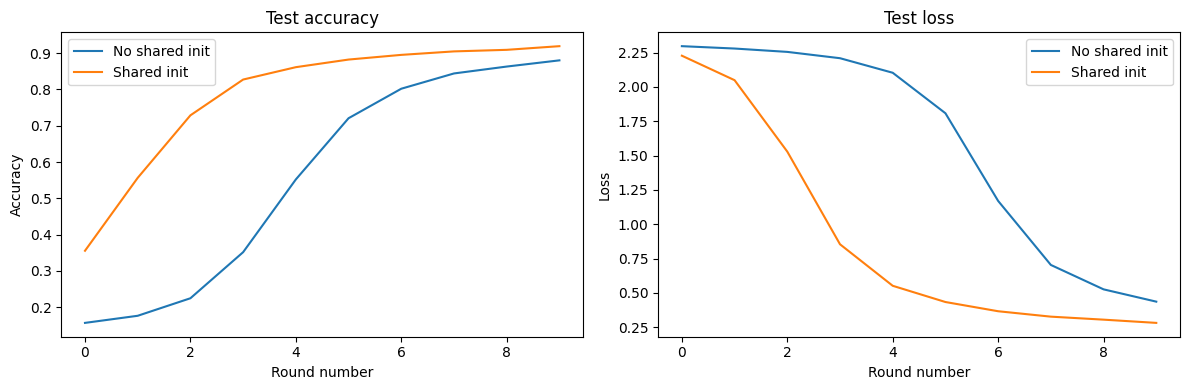

In [14]:
display_history(history_no_init, history_init)

**Answer:**
> As written in the paper, with shared initialization, averaging the models produces a significant reduction in the loss on the total training set. We can also see a faster convergence and higher final accuracy (with shared initialization).

### 9. Reduce the number of data points in each sub-batch. What is the minimum number of data points necessary for the final model to have acceptable performance? Repeat the study on CIFAR-10

### What is the minimum number of data points necessary for the final model to have acceptable performance?

In [15]:
def min_number_datapoints(federated_function: Callable, sizes: list = [50, 100, 200, 300, 400, 600]):
    results = {'size': [], 'accuracy': [], 'loss': []}

    for idx, size in enumerate(sizes):
        print(f"\n=== TEST {idx} with size={size} ===\n")
        history = federated_function(
            average_weight = [0.5, 0.5],
            num_rounds = 10,
            local_epochs = 5,
            shared_init = True,
            subset_size=size
        )

        results['size'].append(size)
        results['accuracy'].append(max(history['accuracy']))
        results['loss'].append(min(history['loss']))

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(results['size'], results['accuracy'], marker='o')
    plt.title('Best accuracy vs dataset size')
    plt.xlabel('Dataset size')
    plt.ylabel('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(results['size'], results['loss'], marker='o')
    plt.title('Best loss vs dataset size')
    plt.xlabel('Dataset size')
    plt.ylabel('Loss')

    plt.tight_layout()
    plt.show()

    return results


=== TEST 0 with size=50 ===

==> device used cuda
Training model 1 | train_loss: 2.270, test_loss: 2.299, test_accuracy: 0.102, 
Training model 2 | train_loss: 2.288, test_loss: 2.298, test_accuracy: 0.129, 
-- Round 1 Federated Model --
==> test_loss = 2.298, test_accuracy = 0.102

Training model 1 | train_loss: 2.247, test_loss: 2.292, test_accuracy: 0.121, 
Training model 2 | train_loss: 2.274, test_loss: 2.291, test_accuracy: 0.155, 
-- Round 2 Federated Model --
==> test_loss = 2.291, test_accuracy = 0.109

Training model 1 | train_loss: 2.225, test_loss: 2.285, test_accuracy: 0.169, 
Training model 2 | train_loss: 2.260, test_loss: 2.284, test_accuracy: 0.210, 
-- Round 3 Federated Model --
==> test_loss = 2.284, test_accuracy = 0.167

Training model 1 | train_loss: 2.204, test_loss: 2.280, test_accuracy: 0.224, 
Training model 2 | train_loss: 2.246, test_loss: 2.277, test_accuracy: 0.244, 
-- Round 4 Federated Model --
==> test_loss = 2.278, test_accuracy = 0.229

Training mode

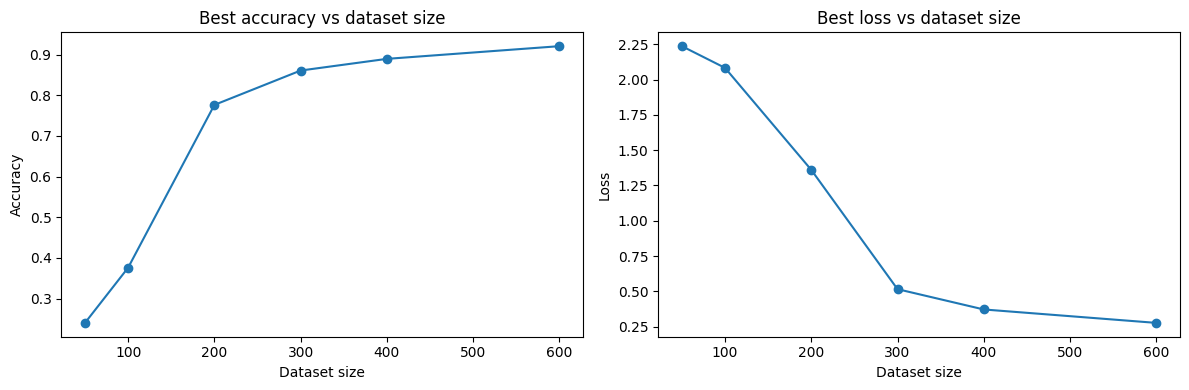

{'size': [50, 100, 200, 300, 400, 600],
 'accuracy': [0.2404, 0.3761, 0.7763, 0.8608, 0.8895, 0.9207],
 'loss': [2.2376059532165526,
  2.0838255405426027,
  1.3608544588088989,
  0.515036529302597,
  0.3711216598749161,
  0.2759631335735321]}

In [16]:
min_number_datapoints(federated_function=federated_averaging)

**Answer:**
> For the MNIST dataset, the minimum number of data points necessary for acceptable model performance is between 300 and 400. At this range, the overall performance are close to the model with 600 data points (within 3-6% accuracy difference), with similar trends observed in the loss.

###  Repeat the study on CIFAR-10

#### Model definition

In [17]:
class CIFAR10CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CIFAR10CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 6 * 6, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.dropout(x)
        x = x.view(-1, 64 * 6 * 6)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

#### Dataset loading and preprocessing

In [18]:
def get_cifar10_data():
    """Load and prepare CIFAR10 dataset"""
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(),
        # ImageNet means and std init
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010))
    ])

    train_dataset = torchvision.datasets.CIFAR10(
        root='./data',
        train=True,
        download=True,
        transform=transform
    )
    test_dataset = torchvision.datasets.CIFAR10(
        root='./data',
        train=False,
        transform=transform,
        download=True,
    )

    return train_dataset, test_dataset

#### Custom training loop

In [19]:
def train_model(
    model: nn.Module, train_loader: DataLoader,
    epochs: int, device: str,
    learning_rate: float,
) -> float:
    """Train model and returns accuracy and loss"""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
    model.train()

    for _ in range(epochs):
        for _, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)

            loss.backward()
            optimizer.step()

    return loss.item()

#### Federated averaging algorithm with custom CIFAR10 compliance functions

In [20]:
def cifar_federated_averaging(
    average_weight: list = [0.5, 0.5], subset_size: int = 6000,
    num_rounds: int = 10, local_epochs: int = 5,
    initial_lr: float = 0.01,
    shared_init: bool = True, device: str = device
):
    """Run federated learning experiment"""
    print(f"==> device used {device}")

    train_dataset, test_dataset = get_cifar10_data()
    train_loader_1, train_loader_2, test_loader = create_subsets(train_dataset, test_dataset, subset_size)

    # Models init
    models = [CIFAR10CNN().to(device), CIFAR10CNN().to(device)]
    training_loaders = [train_loader_1, train_loader_2]

    if shared_init:
        # same initialization for all models
        shared_params = models[0].state_dict()
        models[1].load_state_dict(shared_params)

    current_lr = initial_lr
    history = {'accuracy': [], 'loss': []}

    # Federated learning rounds
    for round_num in range(num_rounds):
        model_id = 1
        for model, t_loader in zip(models, training_loaders):
            loss = train_model(model, t_loader, local_epochs, device, current_lr)
            test_loss, t_accuracy = evaluate_model(model, test_loader, device)
            print(f"Training model {model_id} | train_loss: {loss:.3f}, test_loss: {test_loss:.3f}, test_accuracy: {t_accuracy:.3f}, ")
            model_id += 1

        # Average model parameters
        averaged_params = average_model_parameters(models, average_weight)

        # Update models with averaged parameters
        for model in models:
            update_model_parameters(model, averaged_params)

        # Evaluate global model
        test_loss, accuracy = evaluate_model(models[0], test_loader, device)
        history['loss'].append(test_loss)
        history['accuracy'].append(accuracy)

        print(f"-- Round {round_num + 1} Federated Model --\n==> test_loss = {test_loss:.3f}, test_accuracy = {accuracy:.3f}\n")

        current_lr *= 0.93

    return history

#### Models training with difference hyperparameters

In [21]:
history_no_init = cifar_federated_averaging(
    average_weight = [0.5, 0.5],
    subset_size = 6000,
    num_rounds = 10,
    local_epochs = 5,
    shared_init = False
)

==> device used cuda
Files already downloaded and verified
Files already downloaded and verified
Training model 1 | train_loss: 1.184, test_loss: 1.189, test_accuracy: 0.572, 
Training model 2 | train_loss: 0.874, test_loss: 1.196, test_accuracy: 0.570, 
-- Round 1 Federated Model --
==> test_loss = 2.170, test_accuracy = 0.208

Training model 1 | train_loss: 0.949, test_loss: 1.091, test_accuracy: 0.619, 
Training model 2 | train_loss: 0.869, test_loss: 1.056, test_accuracy: 0.629, 
-- Round 2 Federated Model --
==> test_loss = 1.076, test_accuracy = 0.632

Training model 1 | train_loss: 0.770, test_loss: 1.058, test_accuracy: 0.631, 
Training model 2 | train_loss: 0.642, test_loss: 0.995, test_accuracy: 0.653, 
-- Round 3 Federated Model --
==> test_loss = 0.940, test_accuracy = 0.678

Training model 1 | train_loss: 0.844, test_loss: 0.990, test_accuracy: 0.659, 
Training model 2 | train_loss: 0.654, test_loss: 1.009, test_accuracy: 0.666, 
-- Round 4 Federated Model --
==> test_loss

In [22]:
history_init = cifar_federated_averaging(
    average_weight = [0.5, 0.5],
    subset_size = 6000,
    num_rounds = 10,
    local_epochs = 5,
    shared_init = True,
)

==> device used cuda
Files already downloaded and verified
Files already downloaded and verified
Training model 1 | train_loss: 1.345, test_loss: 1.246, test_accuracy: 0.552, 
Training model 2 | train_loss: 1.079, test_loss: 1.229, test_accuracy: 0.556, 
-- Round 1 Federated Model --
==> test_loss = 1.308, test_accuracy = 0.569

Training model 1 | train_loss: 0.962, test_loss: 1.083, test_accuracy: 0.620, 
Training model 2 | train_loss: 0.865, test_loss: 1.063, test_accuracy: 0.628, 
-- Round 2 Federated Model --
==> test_loss = 0.993, test_accuracy = 0.654

Training model 1 | train_loss: 0.944, test_loss: 1.009, test_accuracy: 0.653, 
Training model 2 | train_loss: 0.728, test_loss: 1.004, test_accuracy: 0.659, 
-- Round 3 Federated Model --
==> test_loss = 0.912, test_accuracy = 0.685

Training model 1 | train_loss: 0.587, test_loss: 0.932, test_accuracy: 0.684, 
Training model 2 | train_loss: 0.440, test_loss: 0.938, test_accuracy: 0.683, 
-- Round 4 Federated Model --
==> test_loss

#### Comparision visualization between shared_init and no_shared_init

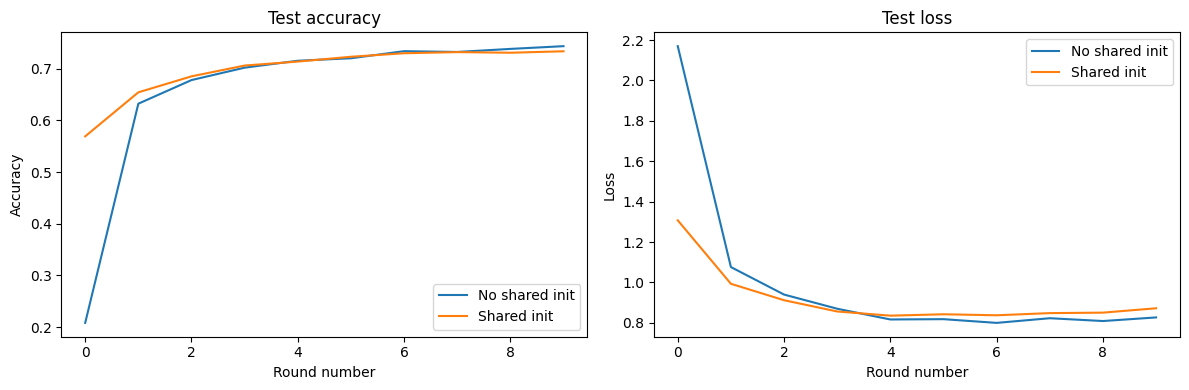

In [23]:
display_history(history_no_init, history_init)

**Answer**
> My implementation of the federated approach showed less advantage on CIFAR-10. While convergence remains faster, the final accuracy/loss is the same. This can be attributed to CIFAR-10 being more challenging to train than MNIST. It's is also important to note that the original paper tested this with 100 different models on 600 datapoints each.

#### What is the minimum number of data points necessary for the final model to have acceptable performance?


=== TEST 0 with size=500 ===

==> device used cuda
Files already downloaded and verified
Files already downloaded and verified
Training model 1 | train_loss: 1.825, test_loss: 1.794, test_accuracy: 0.366, 
Training model 2 | train_loss: 1.709, test_loss: 1.769, test_accuracy: 0.358, 
-- Round 1 Federated Model --
==> test_loss = 1.647, test_accuracy = 0.393

Training model 1 | train_loss: 1.136, test_loss: 1.706, test_accuracy: 0.392, 
Training model 2 | train_loss: 1.003, test_loss: 1.746, test_accuracy: 0.398, 
-- Round 2 Federated Model --
==> test_loss = 1.527, test_accuracy = 0.439

Training model 1 | train_loss: 0.885, test_loss: 1.851, test_accuracy: 0.370, 
Training model 2 | train_loss: 0.794, test_loss: 1.627, test_accuracy: 0.444, 
-- Round 3 Federated Model --
==> test_loss = 1.538, test_accuracy = 0.447

Training model 1 | train_loss: 0.759, test_loss: 1.796, test_accuracy: 0.420, 
Training model 2 | train_loss: 0.733, test_loss: 1.954, test_accuracy: 0.387, 
-- Round 4 F

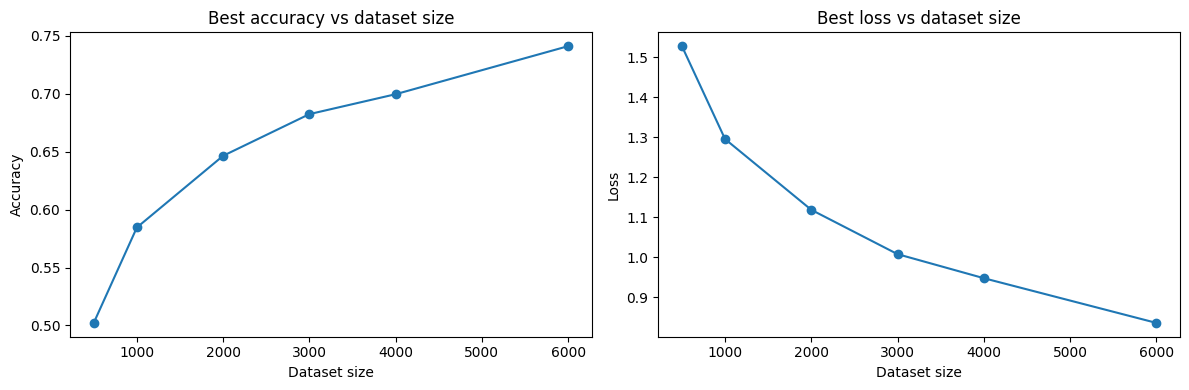

{'size': [500, 1000, 2000, 3000, 4000, 6000],
 'accuracy': [0.5022, 0.5846, 0.6465, 0.6825, 0.6997, 0.7412],
 'loss': [1.5273302435874938,
  1.2952759742736817,
  1.1184809923171997,
  1.007759416103363,
  0.9477048575878143,
  0.8360423862934112]}

In [24]:
min_number_datapoints(
    federated_function=cifar_federated_averaging,
    sizes = [500, 1000, 2000, 3000, 4000, 6000]
)

**Answer**
> The overall performance peaks around 0.75 accuracy. Reducing the dataset from 6000 to 4000 datapoints drops the accuracy from 0.75 to 0.7, with further reductions leading to significant performance degradation.